In [121]:
import os
print("Current directory:", os.getcwd())
print("Git branch:", os.popen('git branch --show-current').read().strip())

Current directory: /home/ileniag/buzi_ml4cad_noncvd
Git branch: noncvd-7y-alive


### Find Best ensemble

Run this code if you need to find the best ensemble among different models combinations. 
Check "top_model" above in this notebook, it's under the "Ensemble" markdown.

In [122]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

In [123]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 27
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = mean_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/27features/
data/27features/


In [124]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standardized
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({np.float64(1.0): 3705, np.float64(0.0): 505})
Counter({np.float64(1.0): 1235, np.float64(0.0): 169})
Counter({np.float64(1.0): 1235, np.float64(0.0): 169})


Calibrating: adaboost_random_bordersmote_adaboost
Calibrating: gb_random_svmsmote_gb
Calibrating: nn_random_svmsmote_nn
Calibrating: lr_random_svmsmote_lr
Calibrating: knn_random_svmsmote_knn
Calibrating: svc_random_svmsmote_svc
Calibrating: xgb_random_bordersmote_xgb
Calibrating: rf_random_svmsmote_rf
##############################################
 Rank: #1 Names: ['lr_random_svmsmote_lr', 'xgb_random_bordersmote_xgb', 'rf_random_svmsmote_rf'], Score: (0.8235776058261265, 0.634282267296395, 0.08534100651732299)
##############################################
 Rank: #2 Names: ['lr_random_svmsmote_lr', 'rf_random_svmsmote_rf'], Score: (0.8223558440936205, 0.6270057737947646, 0.08537614269948672)
##############################################
 Rank: #3 Names: ['gb_random_svmsmote_gb', 'lr_random_svmsmote_lr', 'xgb_random_bordersmote_xgb', 'rf_random_svmsmote_rf'], Score: (0.8242100471935415, 0.6046099068153078, 0.08541399981495529)
##############################################
 Rank: #4 

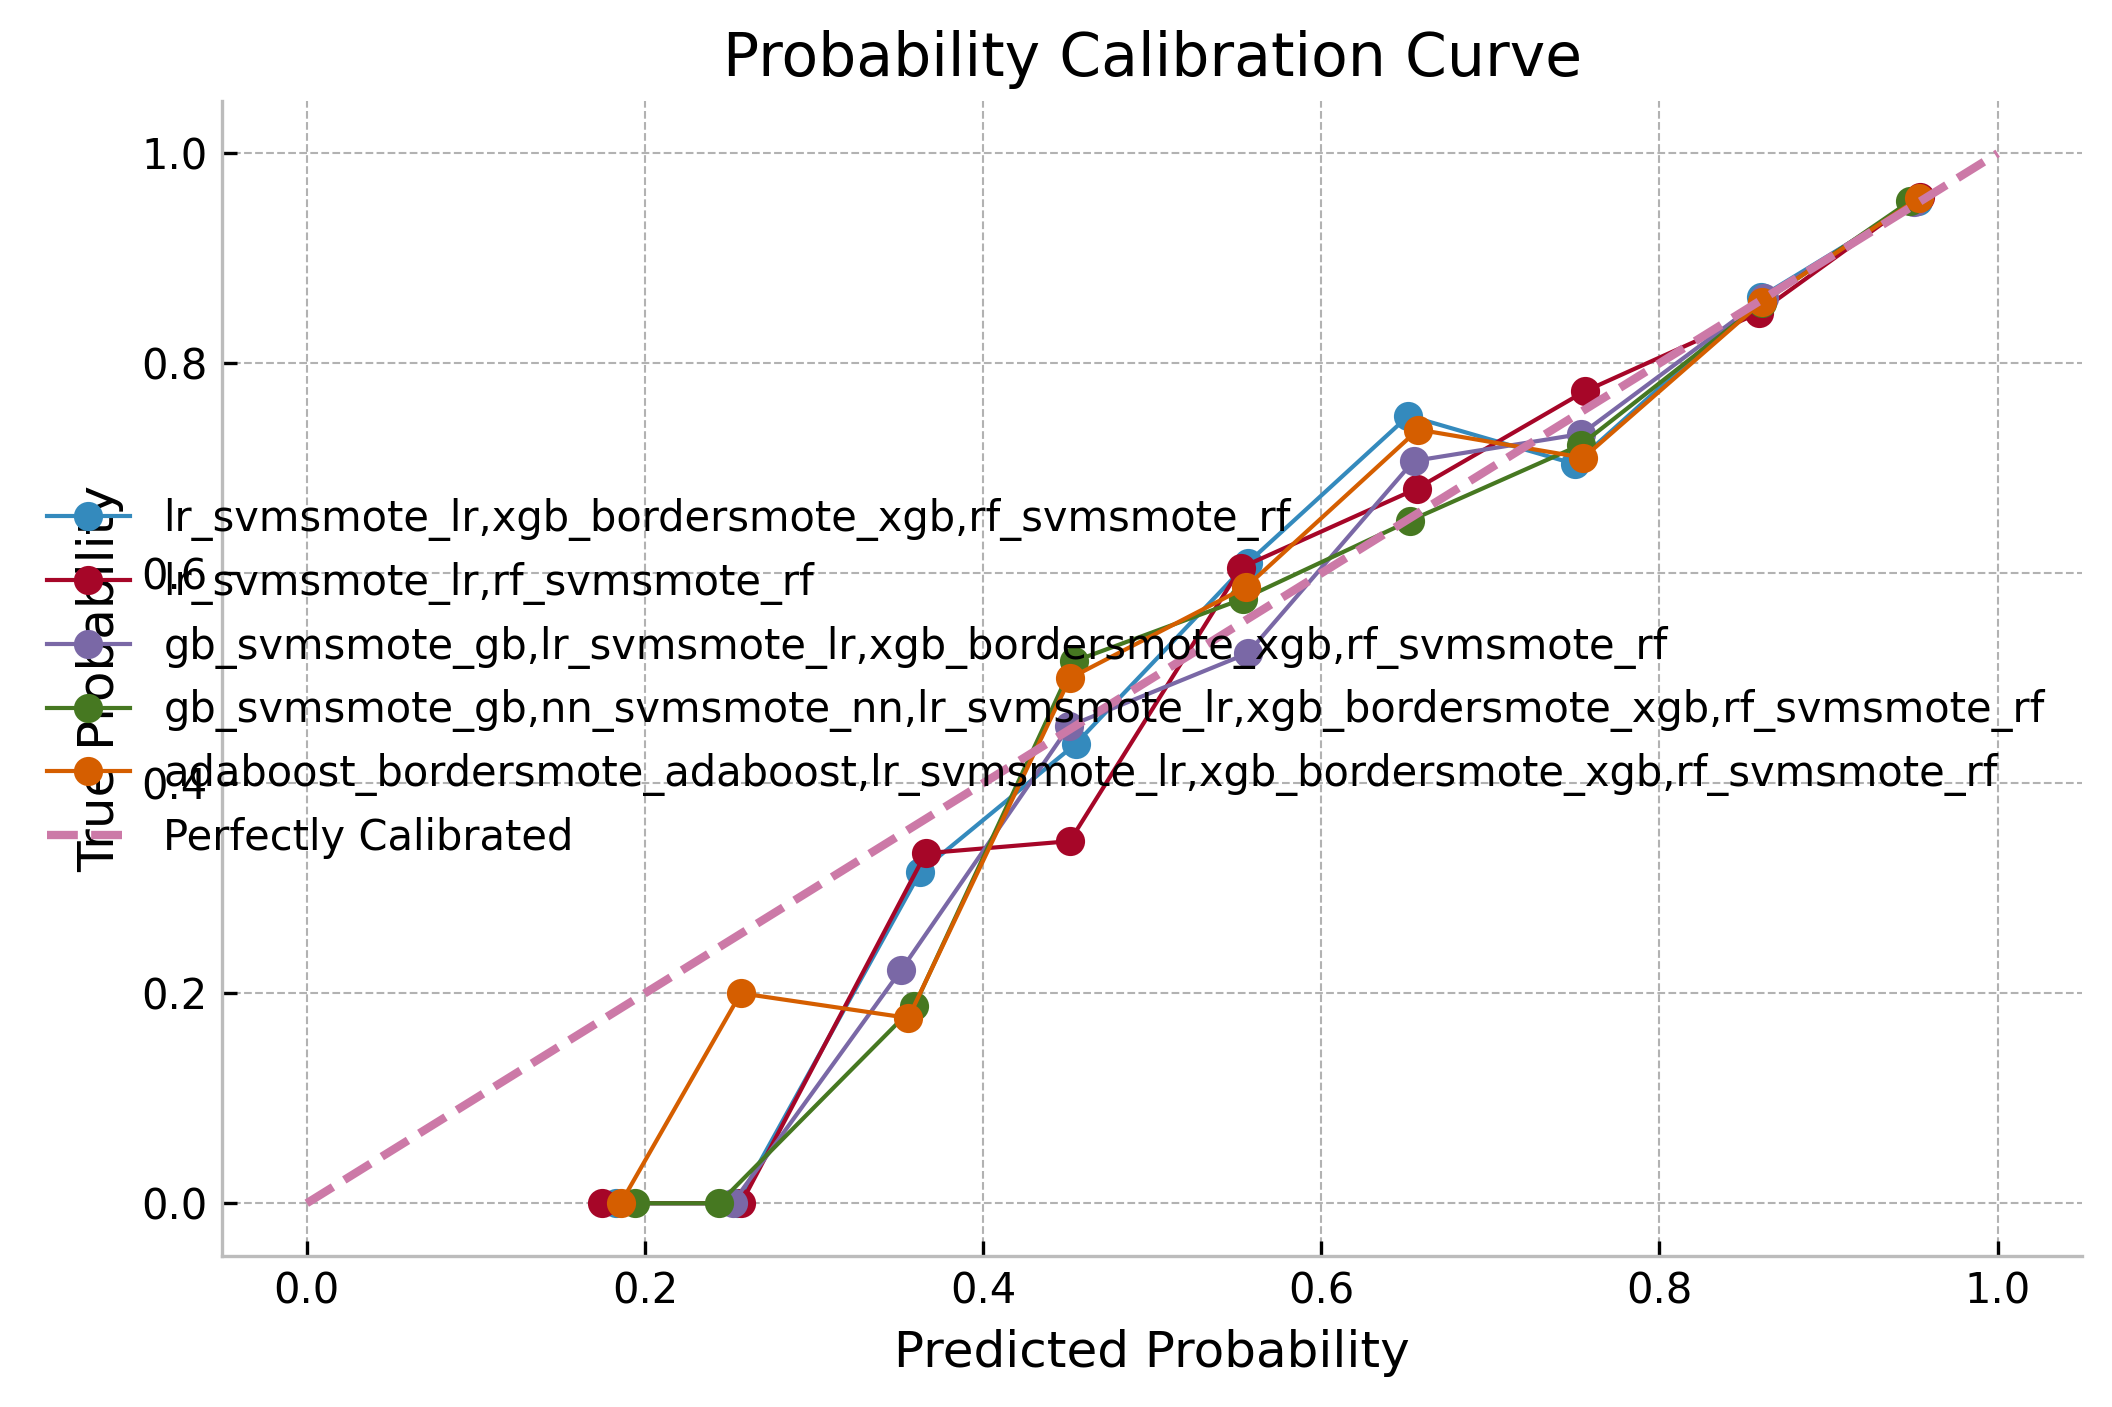

In [125]:
from ensemble import predict_ensemble, find_best_ensemble
from contextlib import redirect_stdout
from joblib import load
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt2
from sklearn.calibration import CalibratedClassifierCV

onlyfiles = [f for f in listdir(path_models) if isfile(join(path_models, f))]
onlyfiles = [model.replace('.joblib', '') for model in onlyfiles]
onlyfiles = [x for x in onlyfiles if not x.startswith('.')]
models = list(filter(lambda x: "random" not in x, onlyfiles))
models = list((x,load(path_models+f"{x}.joblib")) for x in models)
smote_models = list(filter(lambda x: "random" in x, onlyfiles))
smote_models = list((x,load(path_models+f"{x}.joblib")) for x in smote_models)

# Select the list by flipping this variable, this variable it's also used to save the plot in the correct path 
###############
selected = []
selected_models = smote_models
calibrate = True
for name,model in selected_models:
    if calibrate:
        print(f"Calibrating: {name}")
        calibrated_clf = CalibratedClassifierCV(model, cv=5)
        calibrated_clf.fit(X_train, y_train)
        selected.append((name,calibrated_clf))
    else : selected.append((name,model))
###############

ensemble = find_best_ensemble(selected,path_models, X_train, y_train, X_valid, y_valid, False)
valid_prob = None
valid_pred = None
from sklearn.calibration import calibration_curve
for names, model, score in ensemble[:1]:
    train_prob, train_pred = predict_ensemble(model, X_train, y_train)
    valid_prob, valid_pred = predict_ensemble(model, X_valid, y_valid)
    test_prob, test_pred = predict_ensemble(model, X_test, y_test)
    
    print(sum(y_train == train_pred) / len(df_train))
    print(sum(y_valid == valid_pred) / len(df_valid))
    print(sum(y_test == test_pred) / len(df_test))
    
    df_train["ModelOutput"] = train_prob[:, 1]
    df_valid["ModelOutput"] = valid_prob[:, 1]
    df_test["ModelOutput"] = test_prob[:, 1]
    """plt2.hist(valid_prob[:, 1], 
         bins=10,  
         alpha=0.5,  
         label='Calibrated') 
    plt2.legend(loc='upper center') 
    plt2.title('Histogram of Predicted Probabilities') 
    plt2.xlabel('Predicted Probability') 
    plt2.ylabel('Frequency') 
    plt2.show()"""
    ############
for names, model, score in ensemble[:5]:
    valid_prob, valid_pred = predict_ensemble(model, X_valid, y_valid)
    true_pos, pred_pos = calibration_curve(y_valid, valid_prob[:, 1], n_bins=10)
    plt.plot(pred_pos,
             true_pos, 
             marker='o', 
             linewidth=1, 
             label=",".join(names).replace("_random",'')) # Remove random to make names shorter
    
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
suffix = "" if selected_models == models else "_sampling"
suffix += "" if calibrate else "_UNC"
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')
plt.savefig(f"{path_images}calibration_top_five{suffix}.png")
index = 1
with open(f"{path_images}calibration_top_five{suffix}.txt", 'a+') as f:
        with redirect_stdout(f):
            for names, model, score in ensemble[:5]:
                print("##############################################")
                print (f" Rank: #{index} Names: {names}, Score: {score}")
                index +=1

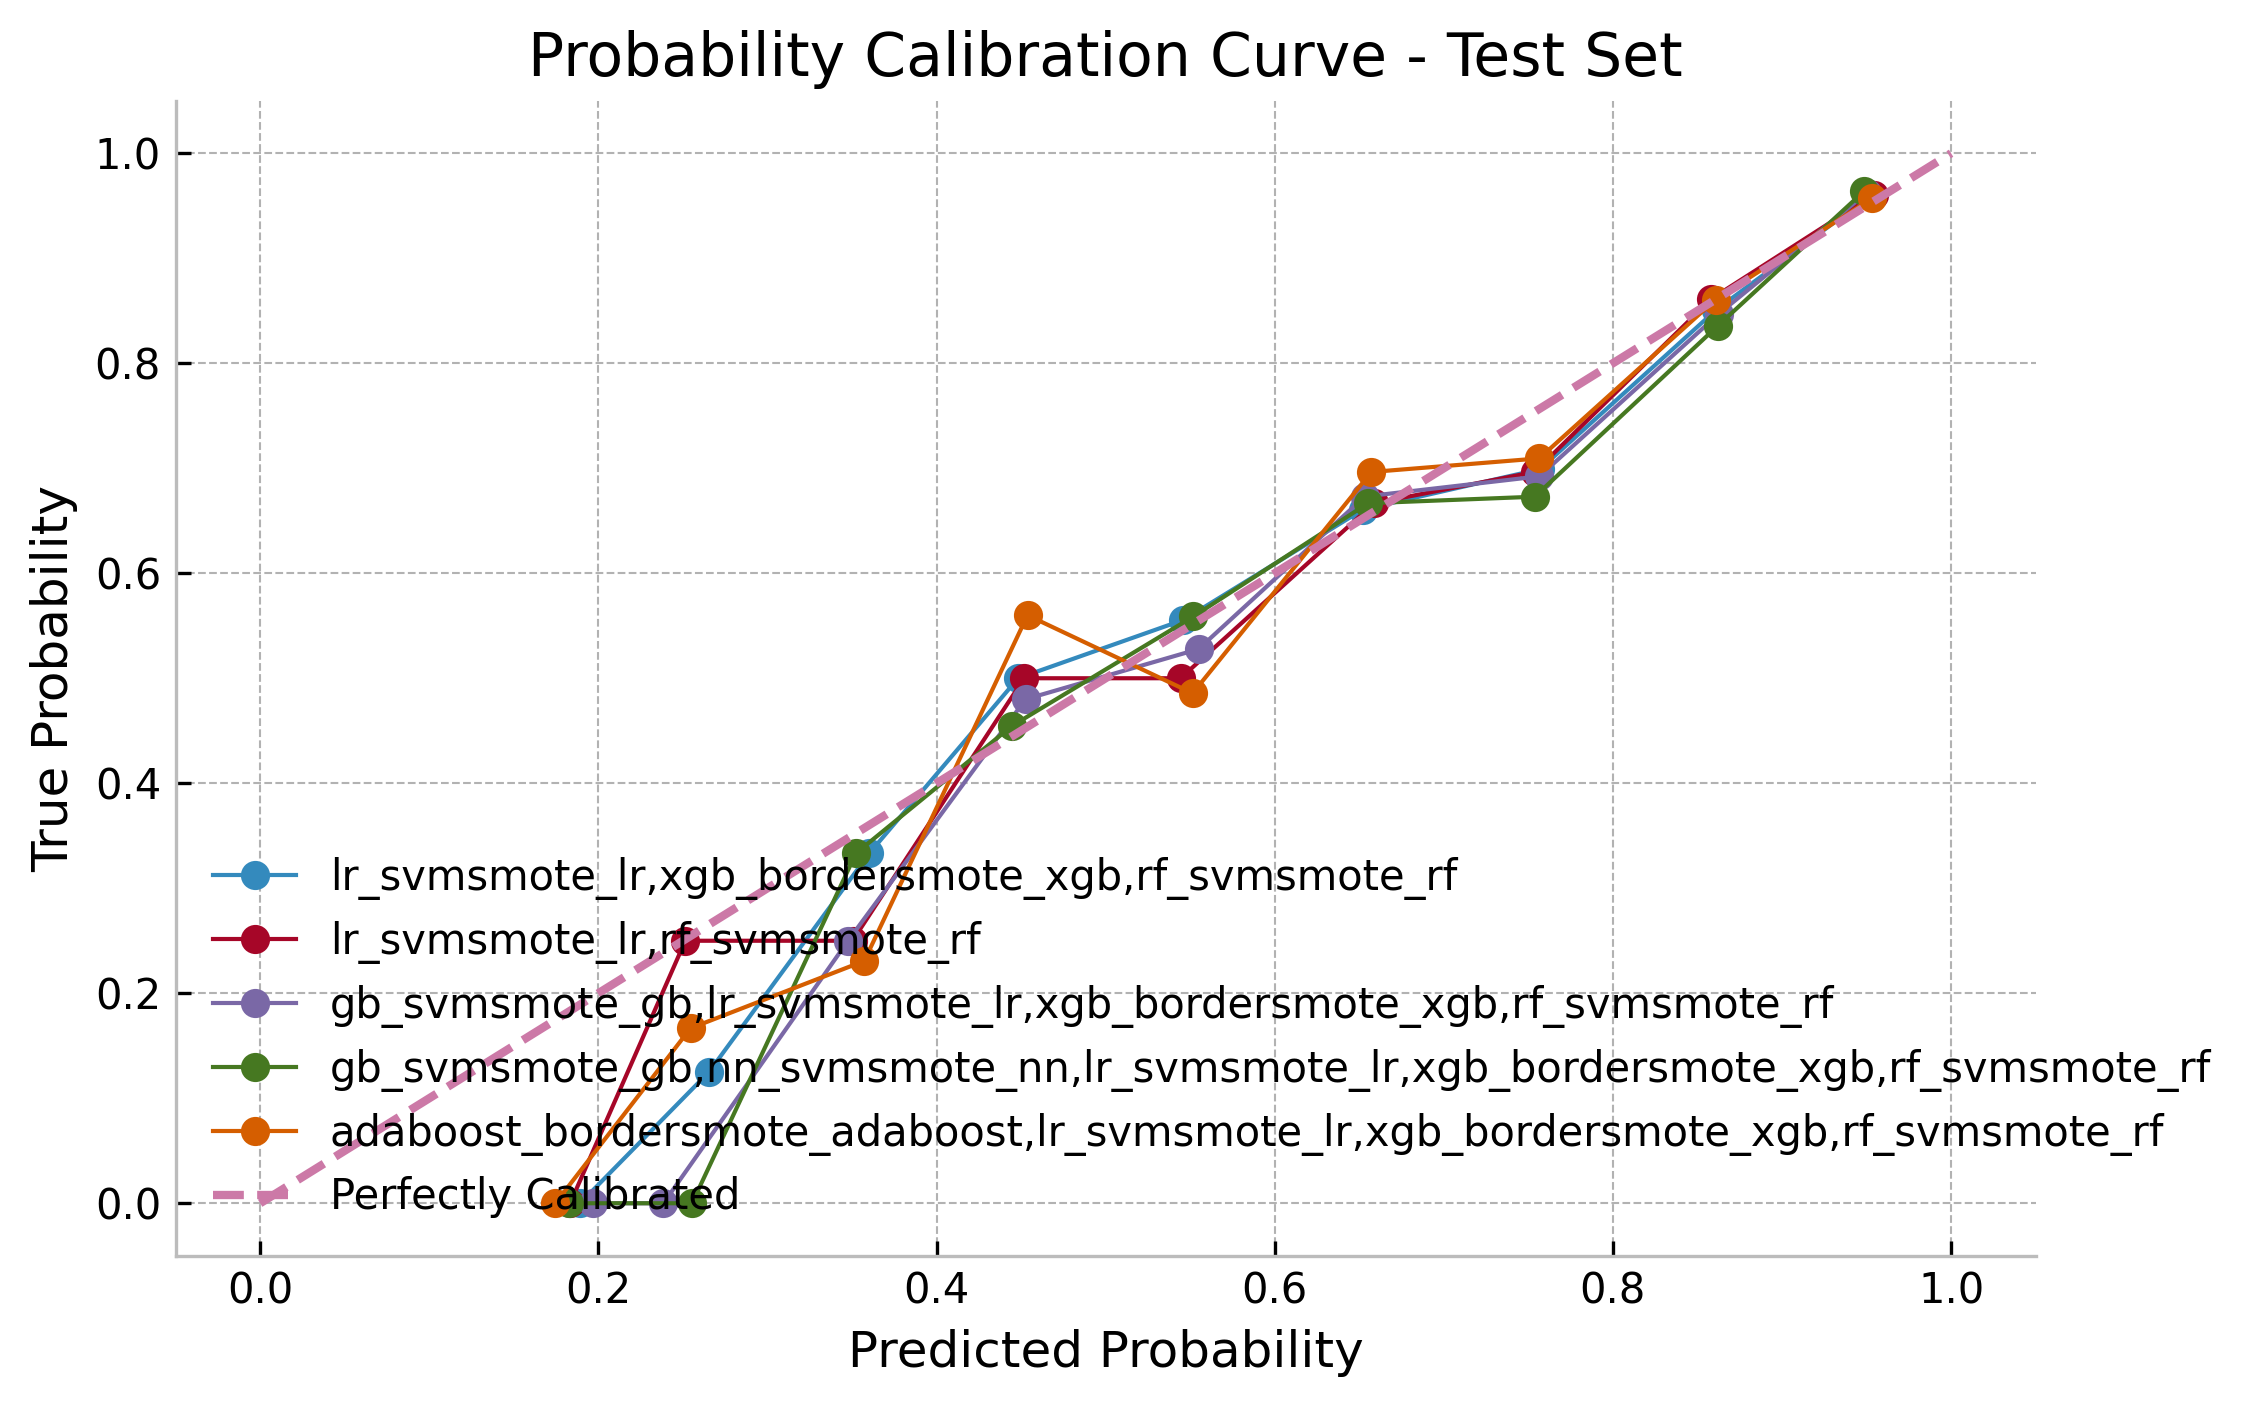


SUMMARY - VALIDATION vs TEST

Rank #1: lr_random_svmsmote_lr, xgb_random_bordersmote_xgb, rf_random_svmsmote_rf
Validation: AUROC=0.824, F1=0.634, Brier=0.085
Test:       AUROC=0.825, F1=0.600, Brier=0.085

Rank #2: lr_random_svmsmote_lr, rf_random_svmsmote_rf
Validation: AUROC=0.822, F1=0.627, Brier=0.085
Test:       AUROC=0.821, F1=0.593, Brier=0.085

Rank #3: gb_random_svmsmote_gb, lr_random_svmsmote_lr, xgb_random_bordersmote_xgb, rf_random_svmsmote_rf
Validation: AUROC=0.824, F1=0.605, Brier=0.085
Test:       AUROC=0.825, F1=0.593, Brier=0.086

Rank #4: gb_random_svmsmote_gb, nn_random_svmsmote_nn, lr_random_svmsmote_lr, xgb_random_bordersmote_xgb, rf_random_svmsmote_rf
Validation: AUROC=0.824, F1=0.615, Brier=0.085
Test:       AUROC=0.826, F1=0.599, Brier=0.085

Rank #5: adaboost_random_bordersmote_adaboost, lr_random_svmsmote_lr, xgb_random_bordersmote_xgb, rf_random_svmsmote_rf
Validation: AUROC=0.823, F1=0.620, Brier=0.085
Test:       AUROC=0.824, F1=0.595, Brier=0.085


In [126]:
from ensemble import evaluate_ensemble
# TEST SET
# Calibration curve - Test set (top 5 ensembles)
plt.figure()
for names, model, score in ensemble[:5]:
    test_prob, test_pred = predict_ensemble(model, X_test, y_test)
    true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
    plt.plot(pred_pos,
             true_pos, 
             marker='o', 
             linewidth=1, 
             label=",".join(names).replace("_random",''))

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Probability Calibration Curve - Test Set')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')
plt.savefig(f"{path_images}calibration_test_top_five{suffix}.png")
plt.show()

# Evaluation on test set - Save detailed results
with open(f"{path_images}calibration_test_top_five{suffix}.txt", 'w') as f:
    with redirect_stdout(f):
        for idx, (names, model, val_score) in enumerate(ensemble[:5], 1):
            print("##############################################")
            print(f"Rank #{idx}: {names}")
            print(f"Validation Score: {val_score}")
            print("\n--- TEST SET ---")
            test_auroc, test_f1, test_brier = evaluate_ensemble(model, X_test, y_test, verbose=True)
            print(f"Test Score: ({test_auroc}, {test_f1}, {test_brier})")
            print("##############################################\n")

# Print summary on console
print("\n" + "="*60)
print("SUMMARY - VALIDATION vs TEST")
print("="*60)
for idx, (names, model, val_score) in enumerate(ensemble[:5], 1):
    print(f"\nRank #{idx}: {', '.join(names)}")
    print(f"Validation: AUROC={val_score[0]:.3f}, F1={val_score[1]:.3f}, Brier={val_score[2]:.3f}")
    test_auroc, test_f1, test_brier = evaluate_ensemble(model, X_test, y_test, verbose=False)
    print(f"Test:       AUROC={test_auroc:.3f}, F1={test_f1:.3f}, Brier={test_brier:.3f}")

In [127]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)


<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_noncvd/exported_notebooks/3.2_find_best_ensemble_27features_20251029_172408.html
